In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn-talk')
from matplotlib import cm
import numpy as np
import os
import scipy.io
import seaborn as sb
from scipy.fftpack import fft
import csv
import pandas as pd
from scipy.signal import butter, filtfilt
import glob
import seaborn as sns
import scikit_posthocs as sp
from scipy import signal

In [3]:
# Pathways
outpath = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\chunking'
figpath = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\chunking\figures'
source = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Centroids_Final\Raw_NG'

In [4]:
#sample data such that there are no NaNs within each path and that each path is greater than 100 frames (fft cannot tolerate NaNs, is removing better than smoothening?)
def removeNaN(df): 
    if np.any(df.X_position.isnull()):
        a = np.asarray(np.where(df.X_position.isnull())).ravel()
        b = a[1:]
        c = a[:-1]
        d = b-c
        last_chunk = len(df.X_position) - a[-1]


        if last_chunk > 100:

            start = a[-1]+1
            end = a[-1] + last_chunk-1

        elif a[0] > 100:
            start = 0
            end = a[0]-1


        elif d.max() > 100:
            e = d.argmax()
            start = a[e]+1
            end = a[e+1]-1

        else:
            print('error')
    
        x_no_nan = df.X_position.values[start:end]
        y_no_nan = df.Y_position.values[start:end]
        return(x_no_nan, y_no_nan)
    else:
        x = df.X_position.values
        y = df.Y_position.values
        return(x,y)

In [5]:
# def rotation_matrix(x_0,y_0,x_1,y_1):
    
#     A = np.asarray([(x_1-x_0), (y_1-y_0)]) # < --- is this counting the point as [(0,0), ((x_1-x_0), (y_1-y_0))] or [(x_1-x0), (y_1-y0)]?
#     B = np.asarray([1,0])
    
#     theta = np.arccos(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))
    
#     if (y_1-y_0) < 0:
#         theta += np.pi
#         c, s = np.cos(theta), np.sin(theta)
#         R = np.array(( ( c,-s ) ,
#                    ( s,c )  ))
    
#     else:
#         c, s = -1*np.cos(theta), np.sin(theta)
#         R = np.array(( ( c,-s ) ,
#                    ( s,c )  ))
    
#     # do I have to shift the points too? so first point becomes origin, and then last point is shifted by the x & y of the first point. This is only used to find magnitude. Rotation matrix angle should hold for other points? each point as a vector with the origin and I rotate all those vectors equally
    
#     return(R, theta)

In [6]:
#Create a sliding window (10 wingbeats@25Hz/wingbeat&100frames/s ---> 40 frame window)
#report every distance vs displacement ratio for each chunk
def tortuosity_ratio(x,y,chunk):
    
    n = np.arange(0,len(x)-chunk,1)
    ratio_list = []
    
    
    for element in n[:140]:
        
        rotated_points = []
        raw_points = []
        shortest_path = np.sqrt((x[element+chunk]-x[element])**2 + (y[element+chunk]-y[element])**2)
        
        
        
        #generate rotation matrix
        
        R = rotation_matrix(x[element], y[element], x[element+chunk], y[element+chunk])
        
        
        actual_list = 0
        i = 0
        while i < len(x[element:element+chunk]):



            actual_path = np.sqrt((x[element:element+chunk+1][i+1]-x[element:element+chunk+1][i])**2 + (y[element:element+chunk+1][i+1]-y[element:element+chunk+1][i])**2)
            actual_list += actual_path

            
            #apply rotation matrix to every point


            C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
            C_rot = R.dot(C)
            raw_points.append(C)
            rotated_points.append(C_rot)
            

            i +=1
        
        #should account for last point, there has to be more efficient way to do this 
        
        
        C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
        C_rot = R.dot(C)
        raw_points.append(C)
        rotated_points.append(C_rot)
        
        ratio = actual_list/shortest_path
        ratio_list.append(ratio)
        
        mean = np.mean(ratio_list)
        std = np.std(ratio_list)
    return(mean, std, ratio_list, rotated_points, raw_points)

In [7]:
df = pd.read_csv(source + '\Centroids_Final_Sham_2_58256.csv')

In [8]:
x,y = removeNaN(df)
mean, std, ratio_list, rotated_points, raw_points = tortuosity_ratio(x,y, 40)

NameError: name 'rotation_matrix' is not defined

In [9]:
x_rotated = []
y_rotated = []
for e in rotated_points:
    x_rotated.append(e[0])
    y_rotated.append(e[1])
x_raw = []
y_raw = []
for e in raw_points:
    x_raw.append(e[0])
    y_raw.append(e[1])

NameError: name 'rotated_points' is not defined

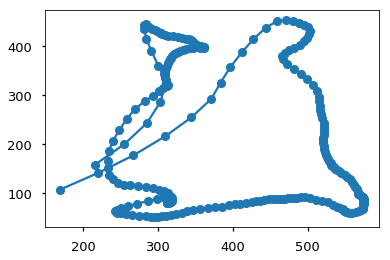

In [596]:
plt.plot(x,y, "-o")

In [5]:
#rotate the data such that the variance from the shortest path is in one dimension

In [6]:
#calculate an fft spectrum 

In [7]:
#average the spectrum across each chunk within a path (considering both the mean and the variance)

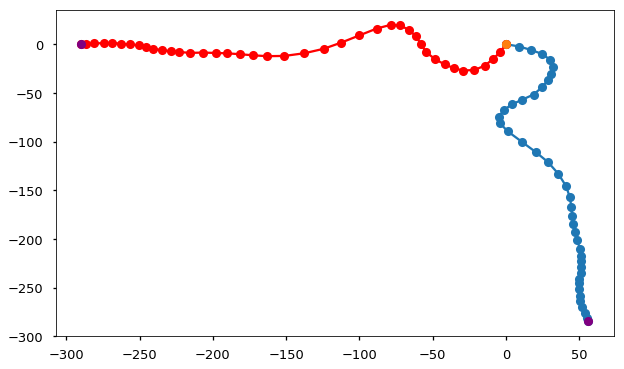

In [48]:
chunk = 40
n = np.arange(0,len(x)-chunk,1)
ratio_list = []

angle_list = []

theta_list = []

for element in n[12:13]:

    rotated_points = []
    raw_points = []
    shortest_path = np.sqrt((x[element+chunk]-x[element])**2 + (y[element+chunk]-y[element])**2)



    #generate rotation matrix

    R, theta = rotation_matrix(x[element], y[element], x[element+chunk], y[element+chunk])
    
    theta = theta*180/np.pi
    
    theta_list.append(theta)

    actual_list = 0
    i = 0
    while i < len(x[element:element+chunk]):



        actual_path = np.sqrt((x[element:element+chunk+1][i+1]-x[element:element+chunk+1][i])**2 + (y[element:element+chunk+1][i+1]-y[element:element+chunk+1][i])**2)
        actual_list += actual_path


        #apply rotation matrix to every point


        C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
        C_rot = R.dot(C)
        raw_points.append(C)
        rotated_points.append(C_rot)


        i +=1

    #should account for last point, there has to be more efficient way to do this 


    C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
    C_rot = R.dot(C)
    raw_points.append(C)
    rotated_points.append(C_rot)
    
    
    x_rotated = []
    y_rotated = []
    for e in rotated_points:
        x_rotated.append(e[0])
        y_rotated.append(e[1])
    x_raw = []
    y_raw = []
    for e in raw_points:
        x_raw.append(e[0])
        y_raw.append(e[1])
    
    plt.figure(figsize=(10,6))
    plt.plot(x_raw[0:], y_raw[0:], "-o")
    plt.plot(x_rotated[0:],y_rotated[0:], "-o", c = 'r')
    plt.plot(x_raw[0], y_raw[0], "-o")
    plt.plot(x_raw[-1], y_raw[-1], "-o", c = "purple")
    plt.plot(x_rotated[-1], y_rotated[-1], "-o", c = "purple")
    
    rotated = np.sqrt((y_rotated[-1]-y_rotated[0])**2 + (x_rotated[-1]-x_rotated[0])**2)
    
    
    
    angle_list.append(np.arccos((x_rotated[0]-x_rotated[-1])/rotated)*180/np.pi)

    ratio = actual_list/shortest_path
    ratio_list.append(ratio)

    mean = np.mean(ratio_list)
    std = np.std(ratio_list)

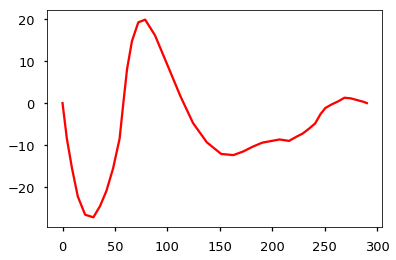

In [49]:
plt.plot(np.asarray(x_rotated)*-1,np.asarray(y_rotated), c = "r")

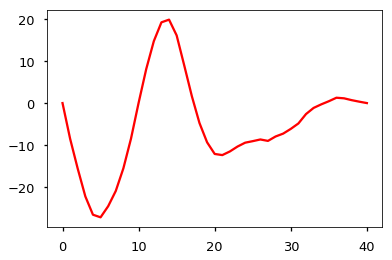

In [50]:
plt.plot(np.arange(0,len(y_rotated)),y_rotated, c = "r")

In [11]:
# i think the problem came from when I had to multiply the values from the roation matrix to the raw values. if the raw values had negative y...
def rotation_matrix(x_0,y_0,x_1,y_1):
    
    A = np.asarray([(x_1-x_0), (y_1-y_0)]) # < --- is this counting the point as [(0,0), ((x_1-x_0), (y_1-y_0))] or [(x_1-x0), (y_1-y0)]?
    B = np.asarray([1,0])
    
    theta = np.arccos(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))
    
    if (y_1-y_0) < 0:
        theta = 2*np.pi-theta
        c, s = -1*np.cos(theta), np.sin(theta) # <--- why does this work? changes the new vector from being on the y-axis to the x-axis in example below (but for data looks like the difference isn't just a 90 degree turn--try angles not at 45)
        R = np.array(( ( c,-s ) ,
                   ( s,c )  ))
    
    else:
        c, s = -1*np.cos(theta), np.sin(theta)
        R = np.array(( ( c,-s ) ,
                   ( s,c )  ))
    
    # do I have to shift the points too? so first point becomes origin, and then last point is shifted by the x & y of the first point. This is only used to find magnitude. Rotation matrix angle should hold for other points? each point as a vector with the origin and I rotate all those vectors equally
    
    return(R, theta)

In [949]:
a = np.asarray([(np.sqrt(2)/2), (np.sqrt(2)/2)])
R, _ = rotation_matrix(0,0,a[0], a[1])
_*180/np.pi

45.0

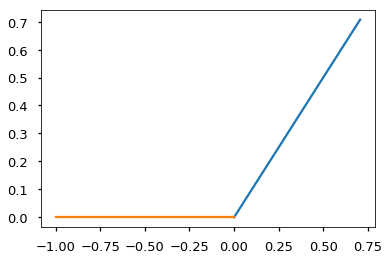

In [950]:
plt.plot([0,a[0]], [0,a[1]])
plt.plot([0,R.dot(a)[0]], [0,R.dot(a)[1]])
# plt.plot([0,1],[0,0])

In [921]:
R.dot(a)

array([-1.00000000e+00, -2.22044605e-16])

In [767]:
#how to summate fft's and average them?
#plot mean spectrum
pre_t = df.loc[:,'FrameNumber']
t = pre_t/100
xvel = df.loc[:,'X_position']
yvel = df.loc[:,'Y_position']

Nx = len(xvel)  #number of points
Nt = Nx
Time = t.values[-1]-t.values[0]   #total sample time (in seconds)c
fs = Nx/Time   # sample frequency
TT = 1/fs  #delta t.
list(xvel)
meanxvel = mean(xvel)

# . fftxvel is complex with real and imaginary part.
#Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
fftxvel = fft(xvel-meanxvel)    # this is the Fourier tranform of the x velocity
xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2) 